In [1]:
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, partial_trace, DensityMatrix

from sklearn.linear_model import Ridge, LinearRegression
import numpy as np

In [2]:
theta_range = np.tile(np.linspace(0,np.pi,10),(5,1)).transpose()

In [6]:
# job = execute(rho,
#               backend=BasicAer.get_backend('statevector_simulator'),
#               parameter_binds=[{a1: theta[0], a2 : theta[1], a3 : theta[2], a4 : theta[3]} for theta in theta_range])


In [7]:
# backend = BasicAer.get_backend('statevector_simulator')
# job = execute(rho, backend)
# qc_state = job.result().get_statevector(rho)
# qc_state

In [8]:
# from qiskit.quantum_info import Statevector, partial_trace

# out = Statevector.from_instruction(rho)
# partial_trace(out,[1])

In [9]:
# partial_trace(out,[1])

In [11]:
# theta = np.random.rand(4)
# rho1 = rho.bind_parameters({a1: theta[0], a2 : theta[1], a3 : theta[2], a4 : theta[3]})
# rho1.measure_all()
# simulator = Aer.get_backend('aer_simulator')
# circ = transpile(rho1, simulator)
# result = simulator.run(circ).result()
# counts = result.get_counts(circ)

In [12]:
IBMQ.providers()

[]

In [14]:
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi
from qiskit import IBMQ
from IBM_Q import API_IBM



IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_manila')

from qiskit.compiler import transpile, assemble



ibmqfactory.load_account:WARNING:2021-06-08 13:30:39,085: Credentials are already in use. The existing account in the session will be replaced.


In [15]:
# shots = 10000
# sim_statevector = Aer.get_backend('aer_simulator_statevector')
# job_statevector = sim_statevector.run(circ, shots=shots)
# counts_statevector = job_statevector.result().get_counts()

In [16]:


# # Transpile for simulator
# simulator = Aer.get_backend('aer_simulator')
# circ = transpile(circ, simulator)

# # Run and get counts
# result = simulator.run(circ).result()
# counts = result.get_counts(circ)
# counts

In [17]:
# from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
# from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
# from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
# import qiskit.ignis.mitigation.measurement as mc
# import qiskit.quantum_info as qi

# # Generate the state tomography circuits.
# qst = state_tomography_circuits(rho1, q)

# # Execute
# job = qiskit.execute(qst, Aer.get_backend('qasm_simulator'), shots=50000)

# # Fit result
# qst_fit = StateTomographyFitter(job.result(), qst)
# qst_fit_fitted = qst_fit.fit(method='lstsq')

In [14]:
F_bell = qi.state_fidelity(qst_fit_fitted, Statevector.from_instruction(rho1))
print('State Fidelity: F = {:.5f}'.format(F_bell))

State Fidelity: F = 0.99950


In [529]:
from qiskit.quantum_info.operators import Operator, Pauli
import scipy
HZZ = Operator(Pauli(label='ZZ')).data
HXX = Operator(Pauli(label='XX')).data

# gibbs_1 = scipy.linalg.expm(-(-0.5*H2 -0.5 *H3 + 0.3*H4 +0.3*H5 + 1*H1))

# gibbs_1 = np.round(gibbs_1,2)


In [950]:
from functions import utils_
from importlib import reload
reload(utils_)

ham_dict = {}
ham_dict['ham'] = ['z']
ham_dict['pos'] = [[0]]
ham_dict['c'] = [3]
VQS_ = utils_.VQS(2)
VQS_.set_ham(ham_dict)
gibbs_1 = scipy.linalg.expm(-(VQS_.return_ham()))


# gibbs_1 = scipy.linalg.expm(-2*H1)
gibbs_1 /= np.trace(gibbs_1)

In [951]:
estimator = utils_.estimate_params(        
        VQS_.V,
        VQS_.pos_est,
        VQS_.gs,
        VQS_.g_pos,
        ham_dict = VQS_.ham_dict,
        n = VQS_.n_params)

In [962]:
from qiskit.quantum_info import Statevector, partial_trace, DensityMatrix
est2 = utils_.estimate_params2(VQS_)

tau = 0
fid_list = []
rho_list = []
N_ = [50]
for N in N_:
    delta = (1/2)/N

    theta = np.zeros(VQS_.n_params)
    i = 0
    while True:
        params = {VQS_.P[i] : theta[i] for i in range(VQS_.n_params)}

        estimator.params = params
        A,C = estimator.estimate_AC(NUM = 10**3)
        
#         est2.params = params
#         A, C = est2.estimate_AC(NUM = 10**3)
        clf = Ridge(fit_intercept=False, alpha=1e-6)
        clf.fit(A, C)
#         clf = LinearRegression().fit(A, C)
        theta += clf.coef_ * delta
        tau += delta
        
        
        
#         gibbs_1_density = DensityMatrix(gibbs_1)
        gibbs_1 = scipy.linalg.expm(-(VQS_.return_ham(boltzmann=True)))
        gibbs_1 /= np.trace(gibbs_1)



        gibbs_1_density = DensityMatrix(gibbs_1)

        
        params = {VQS_.P[i] : theta[i] for i in range(VQS_.n_params)}
        rho1 = VQS_.state().bind_parameters(params)
        out = Statevector.from_instruction(rho1)
        rho1_ = partial_trace(out,[1])

        Fidelity = qi.state_fidelity(rho1_, gibbs_1_density)
        fid_list.append(Fidelity)
        rho_list.append(rho1)
        
        print('i = {} tau={}: F = {:.5f}'.format(i, round(tau,3), Fidelity))

        
        
        if round(tau,3) >= 1/2:
            break
        i += 1


i = 0 tau=0.01: F = 0.58543
i = 1 tau=0.02: F = 0.61694
i = 2 tau=0.03: F = 0.64642
i = 3 tau=0.04: F = 0.67425
i = 4 tau=0.05: F = 0.70039
i = 5 tau=0.06: F = 0.72572
i = 6 tau=0.07: F = 0.75304
i = 7 tau=0.08: F = 0.77501
i = 8 tau=0.09: F = 0.79503
i = 9 tau=0.1: F = 0.81125
i = 10 tau=0.11: F = 0.83069
i = 11 tau=0.12: F = 0.84795
i = 12 tau=0.13: F = 0.86478
i = 13 tau=0.14: F = 0.87737
i = 14 tau=0.15: F = 0.89161
i = 15 tau=0.16: F = 0.90464
i = 16 tau=0.17: F = 0.91628
i = 17 tau=0.18: F = 0.92660
i = 18 tau=0.19: F = 0.93483
i = 19 tau=0.2: F = 0.94368
i = 20 tau=0.21: F = 0.95105
i = 21 tau=0.22: F = 0.95689
i = 22 tau=0.23: F = 0.96267
i = 23 tau=0.24: F = 0.96870
i = 24 tau=0.25: F = 0.97215
i = 25 tau=0.26: F = 0.97619
i = 26 tau=0.27: F = 0.97993
i = 27 tau=0.28: F = 0.98286
i = 28 tau=0.29: F = 0.98547
i = 29 tau=0.3: F = 0.98745
i = 30 tau=0.31: F = 0.98956
i = 31 tau=0.32: F = 0.99272
i = 32 tau=0.33: F = 0.99397
i = 33 tau=0.34: F = 0.99514
i = 34 tau=0.35: F = 0.9962

In [937]:
backend = BasicAer.get_backend('qasm_simulator')
rho1.measure_all()
result = execute(rho1, backend, shots=10**4).result()
result.get_counts(rho1)

{'1010': 7929,
 '0101': 1927,
 '0000': 67,
 '1111': 48,
 '1011': 2,
 '1100': 3,
 '0110': 15,
 '0111': 8,
 '0011': 1}

In [941]:
gibbs_1_density.data[3,3] * 10**4

(871.4431874203257+0j)

## rotate return states and measure fidelity

In [459]:
out = Statevector.from_instruction(rho1)
rho1_ = partial_trace(out,[2,3])


ham_dict = {}
ham_dict['ham'] = ['zz','z','z']
ham_dict['pos'] = [[0,1],[1],[0]]
ham_dict['c'] = [1,0.5,0.3]
VQS2_ = utils_.VQS(4)
VQS2_.set_ham(ham_dict)
gibbs_2 = scipy.linalg.expm(-(VQS2_.return_ham()))


# gibbs_1 = scipy.linalg.expm(-2*H1)
gibbs_2 = scipy.linalg.expm(-(VQS2_.return_ham()))
gibbs_2 /= np.trace(gibbs_2)



gibbs_2_density = DensityMatrix(gibbs_2)
Fidelity = qi.state_fidelity(rho1_, gibbs_2_density)
print("fidelity = {}".format(Fidelity))

fidelity = 0.9999829765553137


In [790]:
reload(utils_)
VQS_ = utils_.VQS(4)
VQS_.set_ham(ham_dict)
params = {VQS_.P[i] : theta[i] for i in range(VQS_.n_params)}
est2 = utils_.estimate_params2(VQS_, params)
C, counts, state = est2.estimate_C(2*10**4)

In [791]:
# _, result = est2.estimate_A(der_pos = 2, NUM = 10**4)
# states = []
# counts = []


# val = np.zeros((len(ham_dict['ham']), len(result)))


# for n, (key, item) in enumerate(result.items()):

#     state_array = np.zeros(len(key), np.int8)
#     for i,j in enumerate(key):
#         state_array[-(i+1)] = -((int(j) * 2) - 1)
#     states.append(state_array)
#     counts.append(item)
#     for m, pos in enumerate(ham_dict['pos']):
        
#         pos_ = [0] + [i+1 for i in pos]
#         val[m,n] = state_array[pos_].prod()
        
# counts = np.array(counts)

In [798]:
# estimator.estimate_AC(NUM = 10**4)

In [774]:
val[0]

array([ 1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.])

In [775]:
result

{'10100': 1685,
 '10101': 905,
 '01010': 2606,
 '11111': 2174,
 '00001': 1692,
 '00000': 688,
 '11110': 170,
 '01011': 79,
 '11011': 1}

In [625]:
S = VQS_.state(boltzmann = True).bind_parameters(params)

rho = partial_trace(Statevector(S),[2,3]).data

In [626]:
H, H_list = VQS_.return_ham(return_list=True, boltzmann = True)

In [627]:
np.diag(rho)

array([0.02410185+0.j, 0.34627539+0.j, 0.50330822+0.j, 0.12631454+0.j])

In [890]:
H = VQS_.return_ham(boltzmann = True)

gibbs = si(-H)

array([[ 1.8+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j, -0.2+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j, -1.2+0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0.8+0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0.2+0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j, -1.8+0.j,
       

## test

In [781]:
q = QuantumRegister(4)
cr = QuantumCircuit(q, name='Fisher')
der_pos = 2
for i in range(8):
    if i == der_pos:
        cr.y(der_pos%4)
    cr.append(VQS_.V[i].to_instruction(),[q[k] for k in VQS_.pos[i]])
params =  {VQS_.V[i].parameters[0] : theta[i] for i in range(8)}
new_c = cr.bind_parameters(params)
Va = Operator(new_c).data

q = QuantumRegister(4)
cr = QuantumCircuit(q, name='Fisher')
for i in range(8):
    cr.append(VQS_.V[i].to_instruction(),[q[k] for k in VQS_.pos[i]])
params =  {VQS_.V[i].parameters[0] : theta[i] for i in range(8)}
new_c = cr.bind_parameters(params)
V = Operator(new_c).data

q = QuantumRegister(4)
cr = QuantumCircuit(q, name='Fisher')

cr.z([0,1])
Hzz = Operator(cr).data

In [782]:
np.diag(1j * V.T.conj() @ Hzz @ Va)

array([-0.63626436+0.j, -0.63624067+0.j,  0.63626427+0.j,  0.63624076+0.j,
        0.63626436+0.j,  0.63624067+0.j, -0.63626427+0.j, -0.63624076+0.j,
       -0.6362627 +0.j, -0.63624185+0.j,  0.63626279+0.j,  0.63624176+0.j,
        0.6362627 +0.j,  0.63624185+0.j, -0.63626279+0.j, -0.63624176+0.j])

In [784]:
est2.estimate_A(der_pos=2)[0]

array([-0.6302,  0.2666, -0.0686])

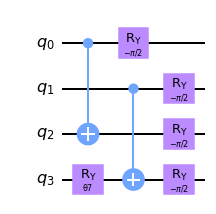

In [730]:
VQS_.V[-1].draw('mpl')